# Description

It runs DBSCAN on the `umap` version of the data.

The notebook explores different values for `min_samples` and `eps` (the main parameters of DBSCAN).

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from utils import generate_result_set_name
from clustering.ensembles.utils import generate_ensemble

# Global settings

In [5]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: umap

## Settings

In [6]:
INPUT_SUBSET = "umap"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
# parameters of the dimentionality reduction steps
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

In [10]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

## Load input file

In [11]:
data = pd.read_pickle(input_filepath)

In [12]:
data.shape

(3749, 50)

In [13]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,11.531590,10.773390,10.551500,5.689103,12.646474,8.795625,2.365859,-3.382425,1.458605,14.236823,...,2.214731,9.304909,3.359118,5.211676,1.265622,2.058685,1.291174,1.565621,7.317275,9.037535
100002_raw-Energy,11.554761,10.753816,10.548004,5.710800,12.674987,8.787647,2.379787,-3.339913,1.442655,14.196218,...,2.237087,9.270699,3.383440,5.185328,1.257113,2.057439,1.290686,1.557209,7.297037,9.009866
100003_raw-Protein,11.519615,10.786408,10.540249,5.687959,12.628188,8.789925,2.368370,-3.390937,1.464806,14.233623,...,2.216162,9.314158,3.350708,5.226166,1.267382,2.051692,1.305047,1.558942,7.307035,9.042575
100004_raw-Fat,11.515584,10.756584,10.570711,5.697041,12.661936,8.787330,2.396913,-3.351611,1.435632,14.221588,...,2.214707,9.273252,3.383349,5.220068,1.270067,2.065669,1.281447,1.578588,7.332527,9.005523
100005_raw-Carbohydrate,11.528723,10.762026,10.566773,5.698555,12.671127,8.791903,2.394764,-3.354370,1.442259,14.226301,...,2.216362,9.275563,3.383139,5.216354,1.269187,2.063429,1.280020,1.577227,7.335059,9.009464


In [14]:
assert not data.isna().any().any()

## Tests different k values (k-NN)

In [15]:
k_values = np.arange(10, 150 + 1, 1)
k_values_to_explore = (10, 15, 20, 30, 40, 50, 75, 100, 125, 150)  # , 175, 200)

In [16]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [17]:
# min_max_range = (1.0, 3)

eps_range_per_k = {
    k: (0.75, 1.25)
    if k == 10
    else (0.85, 1.60)
    if k == 15
    else (1.0, 2.50)
    if k < 40
    else (1.25, 3.0)
    if k < 75
    else (1.25, 3.0)
    if k < 100
    else (1.50, 3.0)
    if k < 175
    else (1.75, 3.0)
    for k in k_values
}

eps_range_per_k_to_explore = {k: eps_range_per_k[k] for k in k_values_to_explore}

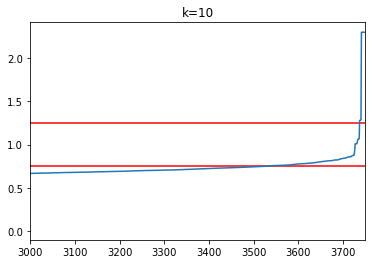

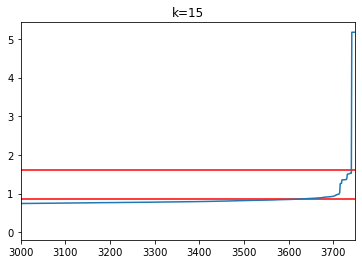

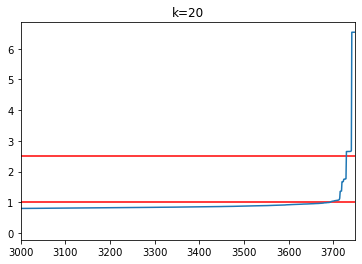

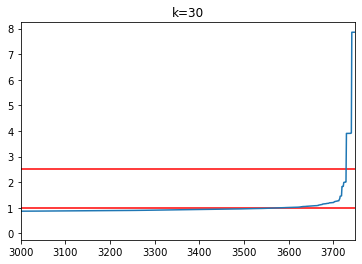

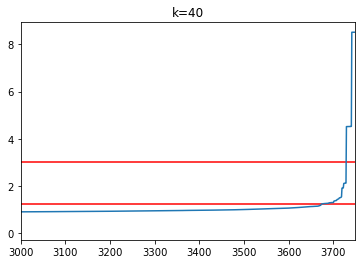

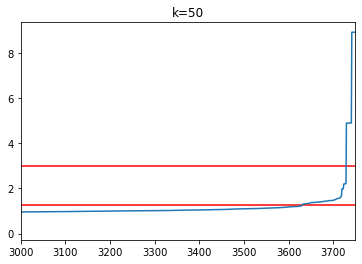

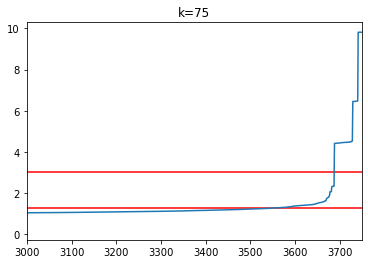

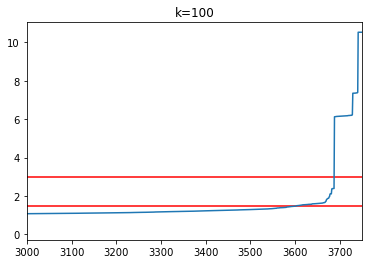

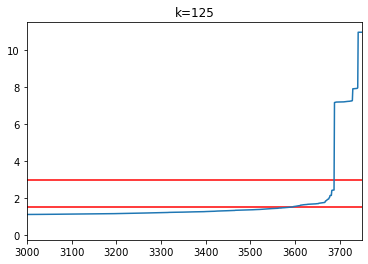

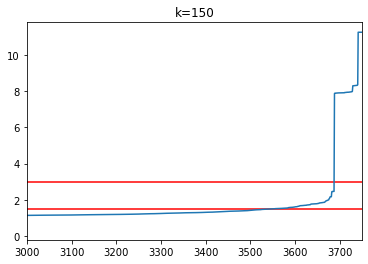

In [18]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

## Clustering

### Generate clusterers

In [19]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]),
 'EPS_RANGE_PER_K': {10: (0.75, 1.25),
  11: (1.0, 2.5),
  12: (1.0, 2.5),
  13: (1.0, 2.5),
  14: (1.0, 2.5),
  15: (0.85, 1.6),
  16: (1.0, 2.5),
  17: (1.0, 2.5),
  18: (1.0, 2.5),
  19: (1.0

In [20]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [21]:
display(len(CLUSTERERS))

4653

In [22]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=0.75, metric='precomputed', min_samples=10, n_jobs=3))

('DBSCAN #1',
 DBSCAN(eps=0.765625, metric='precomputed', min_samples=10, n_jobs=3))

In [23]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

### Generate ensemble

In [24]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [25]:
data_dist.shape

(3749, 3749)

In [26]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14055001.0
mean     2.1742653846740723
std       2.128391742706299
min                     0.0
25%      1.4129530191421509
50%       1.622597336769104
75%      2.1182587146759033
max      15.023402214050293
dtype: object

In [27]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 4653/4653 [12:59<00:00,  5.97it/s]


In [28]:
ensemble.shape

(1056, 3)

In [29]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 0.75, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25
DBSCAN #1,"{'algorithm': 'auto', 'eps': 0.765625, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22
DBSCAN #2,"{'algorithm': 'auto', 'eps': 0.78125, 'leaf_si...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20
DBSCAN #3,"{'algorithm': 'auto', 'eps': 0.796875, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15
DBSCAN #4,"{'algorithm': 'auto', 'eps': 0.8125, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14


In [30]:
ensemble["n_clusters"].value_counts().head()

2    914
3     82
4     34
5     13
9      3
Name: n_clusters, dtype: int64

In [31]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    1056.000000
mean        2.307765
std         1.424557
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        25.000000
Name: n_clusters, dtype: float64

### Testing

In [32]:
assert ensemble_stats["min"] > 1

In [33]:
assert not ensemble["n_clusters"].isna().any()

In [34]:
# assert ensemble.shape[0] == len(CLUSTERERS)

In [35]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [36]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

### Save

In [37]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {},
        #         CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/DBSCAN.pkl')

In [38]:
ensemble.to_pickle(output_filename)